<a href="https://colab.research.google.com/github/Arnoldzyf/Apziva-Projects/blob/main/2_Term_Deposit_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

# Data Pre-processing

## Load the Data

In [ ]:
path = "/content/drive/MyDrive/Apziva/Project 2 - Term Deposit Marketing/Resources/term-deposit-marketing-2020.csv"
data_df = pd.read_csv(f"{path}")
data_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


**Attributes:**

- age : age of customer (numeric)

- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

**Output** (desired target):

- y - has the client subscribed to a term deposit? (binary)


## Statistics

### Label Distribution

In [ ]:
print(data_df["y"].value_counts(normalize=False, dropna=False))
print()
print(data_df["y"].value_counts(normalize=True, dropna=False))

no     37104
yes     2896
Name: y, dtype: int64

no     0.9276
yes    0.0724
Name: y, dtype: float64


- Data is extremely unbalanced

In [ ]:
## Convert Label to Numerics
## Otherwise there'll be errors when using xbg.DMatrix
data_df['y'] = data_df['y'].map({'yes': 1, 'no': 0})

### Data Type and Missing Values

In [ ]:
## Data Type and Missing Values
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


- No obvious missing values
- May need to handle "unknown" values

### Numeric Features

In [ ]:
data_df.describe()

,age,balance,day,duration,campaign,y
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175,0.072400
std,9.641776,2903.769716,8.278127,259.366498,3.239051,0.259152
min,19.000000,-8019.000000,1.000000,0.000000,1.000000,0.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000,0.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000,0.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,1.000000


- Need some rescaling

### Categorical Features

In [ ]:
data_df.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month
count,40000,40000,40000,40000,40000,40000,40000,40000
unique,12,3,4,2,2,2,3,11
top,blue-collar,married,secondary,no,yes,no,cellular,may
freq,9383,24386,20993,39191,24031,33070,24914,13532


In [ ]:
def print_column_value_counts(df, columns, normalize=True, dropna=False):
  for col in columns:
    print(f"------- {col}: --------")
    print(f"-- #unique: {df[col].nunique()}")
    print(df[col].value_counts(normalize=normalize, dropna=dropna))
    print()

print_column_value_counts(df = data_df, \
                          columns = list(data_df.select_dtypes(include='object').columns), \
                          normalize=False, dropna=False)

------- job: --------
-- #unique: 12
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

------- marital: --------
-- #unique: 3
married     24386
single      10889
divorced     4725
Name: marital, dtype: int64

------- education: --------
-- #unique: 4
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

------- default: --------
-- #unique: 2
no     39191
yes      809
Name: default, dtype: int64

------- housing: --------
-- #unique: 2
yes    24031
no     15969
Name: housing, dtype: int64

------- loan: --------
-- #unique: 2
no     33070
yes     6930
Name: loan, dtype: int64

------- contact: --------
-- #unique: 3
cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int6

## Split Data

In [ ]:
## specify the type of categorical data in dataframe
## y is included
cat_attribs = list(data_df.select_dtypes(include='object').columns)
data_df[cat_attribs] = data_df[cat_attribs].astype('category')

In [ ]:
train, test = train_test_split(data_df, test_size=0.2, random_state=42)
# train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Training set has {len(train)} samples")
# print(f"Validation set has {len(val)} samples")
print(f"Test set has {len(test)} samples")

Training set has 32000 samples
Test set has 8000 samples


In [ ]:
X_train = train.drop(columns=['y'])
y_train = train['y']

# X_val = val.drop(columns=['y'])
# y_val = val['y']

X_test = test.drop(columns=['y'])
y_test = test['y']

# Model Development

##5-fold cross validation

Xgboost with 5-fold cross validation -- [explanation & implementation](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance)   

PR curve better suit the problem than the ROC curve in imbalanced dataset (#"0" >> #"1") -- [explanation](https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset)

Use [callbacks](https://xgboost.readthedocs.io/en/latest/python/callbacks.html) to [get the best model](https://stackoverflow.com/questions/66681443/how-can-i-get-the-trained-model-from-xgboost-cv) from `xgb.cv`.


In [ ]:
## define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train, enable_categorical=True)

In [ ]:
## define the callback func that will save the best model in cross validation
class SaveBestModel(xgb.callback.TrainingCallback):
    def __init__(self, cvboosters):
        self._cvboosters = cvboosters

    def after_training(self, model):
        self._cvboosters[:] = [cvpack.bst for cvpack in model.cvfolds]
        return model

In [ ]:
nfold = 5
params = {'objective': 'binary:logistic', "tree_method": "hist"}

cvboosters = []

## num_boost_round is n_estimators in sklearn
## metrics=['aucpr','logloss']
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=nfold, \
                    num_boost_round=150, early_stopping_rounds=10, \
                    metrics=['logloss', 'error', 'aucpr'], seed=123, \ ## early stopped is based on the last metrics
                    callbacks=[SaveBestModel(cvboosters), ])  ## ?? why models are stored in cvboosters?

print(len(cvboosters))
print(cvboosters)
print(len(cv_results))
cv_results[["test-logloss-mean", "test-error-mean", "test-aucpr-mean", "test-aucpr-std"]]

5
[<xgboost.core.Booster object at 0x7d755d274940>, <xgboost.core.Booster object at 0x7d755d2d53f0>, <xgboost.core.Booster object at 0x7d755d2d4490>, <xgboost.core.Booster object at 0x7d755d2d6e90>, <xgboost.core.Booster object at 0x7d755d2d6c50>]
22


,test-logloss-mean,test-error-mean,test-aucpr-mean,test-aucpr-std
0,0.236061,0.072500,0.492006,0.024554
1,0.204765,0.070062,0.519821,0.019570
2,0.184854,0.066437,0.532232,0.014596
3,0.171825,0.064750,0.532676,0.014924
4,0.162509,0.063438,0.538662,0.020630
5,0.156103,0.063250,0.541079,0.021525
6,0.151481,0.062719,0.544185,0.024102
7,0.147783,0.062469,0.549268,0.023752
8,0.145371,0.062406,0.549678,0.023458
9,0.142891,0.062312,0.553145,0.022868


?? What is contained in the the return value of xgb.cv (i.e. `cv_results`)?
- Case A: nfold = [2,3,4,5], each with `num_boost_round=150, early_stopping_rounds=10`
  - We got `len(cv_results) = [16, 22, 11, 22]`
- Casw B: nfold = [2,3,4,5], each with `num_boost_round=50` and disabtle ~`early_stopping_rounds=10`~
  - We got `len(cv_results) = [50, 50, 50, 50]`

?? Hence, probably `cv_results` only contains the training history of the best (or last) model of the last(or the best-performed?) fold.
- **Best model when `early_stopping_rounds` is specified and `num_boost_round` is not reached. (True, according to [the official Doc](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.cv))**
- Last model when `num_boost_round` is reached (before early stopping or `early_stopping_rounds` is disabled)
- Not sure which fold is in it    

Because,
- If `cv_results` contains all the results of all the nfolds, then Case B should result in `len(cv_results) = 50 * nfold`, but it is not.
- If `cv_results` contrains results when metrics going worse (the increasing aucpr) on the val set, we should see the decreasing `test-aucpr-mean` in it, but not.

?? did not find any documentation on whether all n folds are included in the return value of xgb.cv



## Model & Evaluation

- According to `test-error-mean`, the accuracy has reached above 99% in cross validation.
- We need other metrics (the classification report) of the model.    
  How to get the needed model:
  - As we have saved our best model in `cvboosters`, we can use anyone of it theorically.
  - Or, as we know, from the `cv_results`, we can retrain a model on the `X_train` using `#iterations = len(cv_results)` and keep other params the same.

In [ ]:
xgb_clf = cvboosters[-1]  ## get the best model in the last fold

X_test_dmatrix = xgb.DMatrix(data=X_test, enable_categorical=True)

y_test_proba = xgb_clf.predict(X_test_dmatrix)
y_test_ = (y_test_proba > 0.5).astype(int)

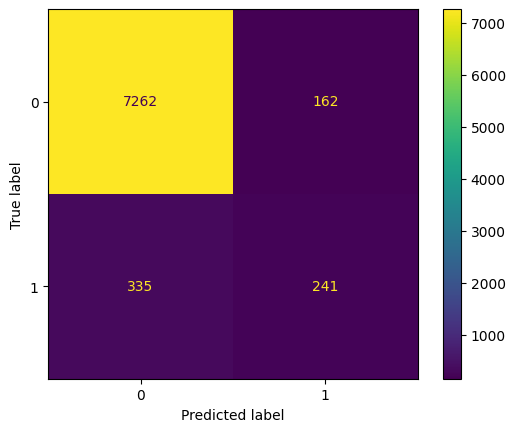

In [ ]:
label=[0,1]
cm_test = confusion_matrix(y_test, y_test_, labels=label)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label)
disp_test.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_test_))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7424
           1       0.60      0.42      0.49       576

    accuracy                           0.94      8000
   macro avg       0.78      0.70      0.73      8000
weighted avg       0.93      0.94      0.93      8000



- **!! Around 40% of the samples that are predicted as "1" are wrong (should be "0").**